# MIDS - W261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW11


---
__Name:__  Alex Smith  
__Class:__ MIDS W261 (Summer 2016 Group 2)     
__Email:__ aksmith@iSchool.Berkeley.edu     
__Week:__  11

***
## Useful references
- [Spark Quick Reference](http://spark.apache.org/docs/latest/quick-start.html)
- Synchronous Slides for Week 11
- [Quora: L1 & L2 Regularization](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization)
- [Andrew Ng's CS229 Lecture Notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf)
- [Sample Logistic Regression Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/r20ff7q0yni5kiu/LogisticRegression-Spark-Notebook.ipynb)
- [Sample SVM Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dm2l73iznde7y4f/SVM-Notebook-Linear-Kernel-2015-06-19.ipynb)

***
## Start up Spark

In [62]:
import os
import sys

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print sc
print sqlContext

***
## <span style="color:teal">HW11.0  Broadcast versus Caching in Spark</span>
<span style="color:gray">What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.
<br><br>
Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:
- [Notebook](https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0)
- [Notebook via NBViewer](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb)</span>

We broadcast a variable but cache a resilient distributed dataset (RDD). When we broadcast a variable, we send the variable to each node in the cluster and store it there. When we cache an RDD, we store in the RDD in a cluster-wide cache. Both of these methods are useful for storing data that we use repeatedly. However, they are used differently. It's helpful to think about these differences through examples. When performing KMeans in Spark, we'll want to broadcast the intermediary centroid values but cache the data points for which we're attempting to find to clusters. We broadcast the centroid values so that each node in the cluster in the cluster has access to the centroid values and each map function does not need to pull the centroid data fresh. We cache the RDD because we reference the dataset multiple times. If we don't cache the dataset, each time we loop through it to find the nearest centroid for each point, then we need to reload it. If instead, we cache the dataset, then we'll store in the dataset in memory after the first iteration.

Reference: [Broadcast](http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables), [Cache](http://spark.apache.org/docs/latest/quick-start.html#caching), and [StackOverflow](http://stackoverflow.com/questions/28981359/why-do-we-need-to-call-cache-or-persist-on-a-rdd)

Because I'm only submitting a single notebook, I'll only include the code snippet that changed here. For the full code, we can look at HW10 submission which had this KMeans code made more efficient.

We broadcast the intermediary centroid values to each node. Because we compare each datapoint to the list of all centroids to identify the closest centroid, we have efficiency gains by storing the centroids with each node.

In [ ]:
# set the number of iterations
ITERATIONS = 100

# set the interesting iterations
INTEREST = [1,10,20,100]

# set the iterations we want
# to record errors for
ERROR_INTEREST = [1, 10, 20, 30, 40, 50, 100]

# create a list to hold our 
# error for each iterations
errors = []

# set the current iteration
iteration = 0 

# while the iteration is less than 
# the number of iterations
while iteration <= ITERATIONS:
    
    # BROADCASTING MODIFICATION TO CODE
    # broadcast the centroids to each node
    broad_centroids = sc.broadcast(centroids)
    
    # take each line of data and 
    # find its nearest neighbor
    _nearest = parsedData.map(lambda x: findNearest(x,np.array(broad_centroids.value)))
    
    # and then reduce by key
    # to get the sum of all points
    # and the number of data points
    _summed = _nearest.reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
    
    # and then reduce by dividing 
    # the sum of points by the 
    # total number of points
    new_centroids = _summed.map(lambda x: x[1][0]/x[1][1]).collect()
    
    # convert the new_centroids to 
    # numpy array
    centroids = np.array(new_centroids)
    
    # calculate the WSSE for this model by computing
    # the distance between each point and its assigned
    # centroid
    
    # first calculate the error for each point
    _error_each = _nearest.map(lambda x: sqError(x,centroids))

    # then calculate the total error
    _error_total = _error_each.reduce(lambda x,y: x+y)
    
    # increment the iterator
    iteration = iteration + 1
    
    # check to see if this is an iteration
    # where we want to record the error
    # if it is, then record it
    if iteration in ERROR_INTEREST:
        info = iteration,_error_total
        errors.append(info)
    
    # check to see if this an iteration
    # of interest, one that we would
    # like to plot
    if iteration in INTEREST:
        
        # print out the iteration 
        # and the centroids
        print "Iteration", iteration
        print "WSSSE:", _error_total
        print "Centroids:"
        print centroids

        # plot the centroids and the data
        plotKMeans(centroids,data)

        print "\n"
        
# convert the errors to a numpy array
# and write them to file
errors = np.array(errors)
np.savetxt('errors.csv',errors,delimiter = ',')

***
## <span style="color:teal">HW11.1  Loss Functions</span>
<span style="color:gray">In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regesssion learning algorithm? <br><br>
In your reponse, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.<br><br>
In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm? <br><br>
[OPTIONAL]: generate an artifical binary classification dataset with 2 input features and plot the learnt separating surface for both a linear SVM and for  logistic regression. Comment on the learnt surfaces. Please feel free to do this in Python (no need to use Spark).</span>

### SVM versus Logistic Regression
In the context of binary classification problems, the linear Support Vector Machine (SVM) will yield a very similar result to the L2 penalized logistic regression learning algorithm. However, it is still important to remember the differences between the two. The SVM calculates a decision boundary to classify each example. The logistic regression algorithm calculates the problability that an example is in one or the other class. With SVM, we care only about the edge cases, those that are close to the boundary. With logistic regression, we care about all cases, even if we decrease teh weight of those examples far from the boundary with ridge regularization. 

**SVM Loss Function**
$$\sum_{i=1}^{N}[1-y_{i}*W\vec{x}_{i}]_{+}$$

**Logistic Regression L2 Loss Function**
$$\sum_{i=1}^{N}[(y_{i}-W\vec{x}_{i})^{2}]$$

We can see the difference between the loss functions graphically. For logistic regression, we calculate some training error even for correctly classified examples. In the case of hinge loss for SVM, we don't worry about these clearly correctly calculated examples.
<img src="https://dl.dropboxusercontent.com/u/37624818/W261_Week11/SVMvLogistic.png" alt="Loss" style="width: 500px;"/>
*[Image source:Quora](https://www.quora.com/Is-logistic-regression-with-regularization-similar-in-a-conceptual-sense-to-simple-linear-SVM)*

### SVM versus Perceptron
In the context of binary classification problems, the linear Support Vector Machine (SVM) algorithms does not yield the same results as a perceptron algorithm. Intuitively, we think of the perceptron algorithm as stopping once it has successfully classified all the data. However, the linear SVM attempts to find the hyperplane that is furtherest from all the datapoints. This means that it creates more of a buffer between the classes. We can also look at the loss functions as a way of understanding this.<br><br>
**SVM Loss Function**
$$\sum_{i=1}^{N}[1-y_{i}*W\vec{x}_{i}]_{+}$$
**Perceptron Loss Function**
$$\sum_{i=1}^{N}[max(0,-W\vec{x}_{i}*y_{i})]$$

The SVM loss function is a hinge loss function that is always working. It produces continuous values that we must optimize. However, the perceptron loss function only creates discrete values, 0 or the value of the incorrectly classified point. Once all points are correctly classified, the perceptron loss function stops working.

***
## <span style="color:teal">HW11.2 Gradient descent</span>
<span style="color:gray">In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?
<br><br>
Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details)</span>

In the context of logistic regression, we can think of 3 flavors of penalized loss functions that are **all** supported by Spark's MLLib. The 3 flavors are of the regularizer:
- L1 (or Lasso) Regularization
- L2 (or Ridge) Regularization
- None (no regularization)

These three flavors all have different effects and penalize the complexity of the model in different ways. For **L1 (Lasso) Regularization**, we penalize the model by adding to the loss function a component that sums the absolute values of the coefficients. We penalize the axes more (see image below). Therefore, with Lasso regularization we can take the noisy, but useless, features and reduce them to zero. For **L2 (Ridge) Regularization**, we penalize the the complexity of the model by taking the square root of the sum of the squares of the coefficients. With this regularization, we do not bring the noisy, but useless, features to zero, instead we end up bringing them very close to zero. Ultimately, the goal of both types of regularization is to penalize the model-maker for making overly complex that overfit the data. The third flavor is **no regularization** which doesn't provide a penalty for model complexity. The risk with this approach is that the model can get increasingly complex until it overfits the training data.

<img src="https://dl.dropboxusercontent.com/u/37624818/W261_Week11/LassoVRidge.png" alt="RdigeVLasso" style="width: 500px;"/>
*[Image source](http://gerardnico.com/wiki/data_mining/lasso)*

***
## <span style="color:teal">HW11.3  Logistic Regression</span>
<span style="color:gray">Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.</span>
```
def generateData(n):
 """ 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
 return inputs
```
<span style="color:gray">Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets.<br>
<br>
NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.<br>
<br>
Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words.<br>
<br>
Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm.<br>
<br>
Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm):<br>
weight(X)= 1/||X||,<br>
where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)<br>
Here X is vector made up of X1 and X2.<br>
<br>
Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.<br>
<br>
Does Spark MLLib have a weighted LASSO logistic regression implementation? If so, use it and report your findings on the weighted training set and test set. </span>

### Write a function generate linearly separable data

In [13]:
import numpy as np
from numpy.random import rand

def generateData(n):
    """generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label"""

    xb = (rand(n)*2-1)/2-0.5
    yb = (rand(n)*2-1)/2+0.5
    xr = (rand(n)*2-1)/2+0.5
    yr = (rand(n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return np.array(inputs)

### Generate two samples of linearly separable data

In [28]:
import numpy as np

# generate the two sets and save them
linear_test = generateData(50)
linear_train = generateData(50)
np.savetxt('linear_test.csv',linear_test,delimiter=',')
np.savetxt('linear_train.csv',linear_train,delimiter=',')

# preview one of the files
!head linear_test.csv

-8.123969270731652426e-01,4.876178687364305375e-01,1.000000000000000000e+00
7.263460494316192895e-01,-3.348179321123132546e-01,-1.000000000000000000e+00
-4.508612046355497949e-02,5.753135195168691540e-01,1.000000000000000000e+00
9.143251338039184439e-01,-2.963493722042721545e-01,-1.000000000000000000e+00
-8.051971018716123085e-01,4.383609086082024264e-01,1.000000000000000000e+00
6.253994429442213399e-01,-2.339894688503001419e-01,-1.000000000000000000e+00
-5.630718827020542161e-02,7.435254412477608765e-01,1.000000000000000000e+00
5.584572001614525050e-01,-7.010231059007312471e-01,-1.000000000000000000e+00
-5.343047817040319503e-01,3.224654342907674609e-01,1.000000000000000000e+00
8.408044493923740870e-01,-4.418302514143426230e-01,-1.000000000000000000e+00


### Write a function to graph the data

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def graphLabelled(data,title,color1='red',color2='blue'):
    """function that takes an input data, 2D, with
    a third column for the label. splits the data
    into two data sets and plots the two data sets
    with two different colors"""
    
    # split the data
    set1 = data[data[:,2]==-1]
    set2 = data[data[:,2]==1]
    
    # plot each set
    plt.scatter(set1[:,0],set1[:,1],color=color1)
    plt.scatter(set2[:,0],set2[:,1],color=color2)
    
    # set the title
    plt.title(title)
    
    # show the plot
    plt.show()

### Plot the training and test data sets

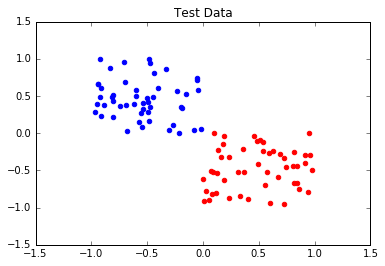

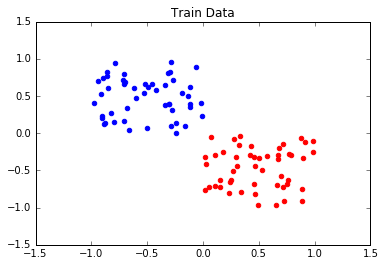

In [30]:
graphLabelled(linear_test,'Test Data')
graphLabelled(linear_train,'Train Data')

### Modify function to generate mostly linearly separable data

In [31]:
import numpy as np
from numpy.random import rand

def generateDataMix(n,mix=0.2):
    """generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    we add the mix variable that controls what percentage of
    datapoints are mixed into the other set"""

    xb = (rand(n)*2-1)/2-0.5
    yb = (rand(n)*2-1)/2+0.5
    xr = (rand(n)*2-1)/2+0.5
    yr = (rand(n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    
    # convert the inputs to a numpy
    # array
    inputs = np.array(inputs)
    
    # generate the indexes of the examples
    # that we would like to swap
    swap = np.random.randint(0, n, size=mix*n)
    
    # loop through all those we wish to swap 
    # and swap their classifications
    for i in swap:
        
        # reset the current class by multiplying
        # it by negative 1
        inputs[i][2] = inputs[i][2] * -1
    
    return inputs

### Generate two samples of non-linearly separable data

In [34]:
import numpy as np

# generate the two sets and save them
test_nl = generateDataMix(50)
train_nl = generateDataMix(50)
np.savetxt('test_nl.csv',test_nl,delimiter=',')
np.savetxt('train_nl.csv',train_nl,delimiter=',')

# preview one of the files
!head test_nl.csv

-2.618683910779338042e-01,1.077429623389888347e-01,1.000000000000000000e+00
5.939108962681916015e-01,-7.458136787099975962e-01,-1.000000000000000000e+00
-3.439924272428942498e-01,7.103026844058518696e-01,1.000000000000000000e+00
6.988877821006941327e-01,-1.956489679893546052e-01,-1.000000000000000000e+00
-4.011297665342470342e-01,3.331525315676561183e-01,1.000000000000000000e+00
8.110004700803218336e-01,-5.077755052062663532e-01,-1.000000000000000000e+00
-8.589843557665196583e-01,1.022412635392887514e-01,1.000000000000000000e+00
2.002743001569864401e-01,-3.494729676869504642e-01,-1.000000000000000000e+00
-6.230482830164917329e-01,2.561716713378526800e-01,1.000000000000000000e+00
1.066077316613961434e-01,-3.126209406904745247e-01,-1.000000000000000000e+00


/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Plot the training and test data sets

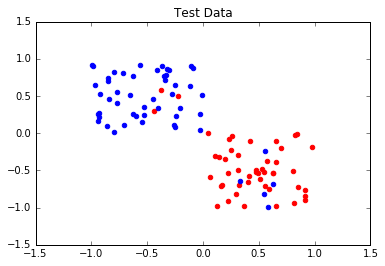

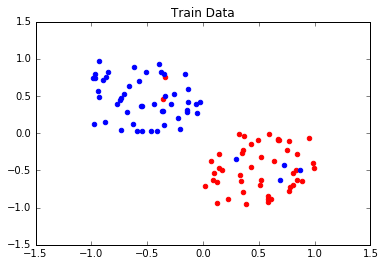

In [35]:
graphLabelled(test_nl,'Test Data')
graphLabelled(train_nl,'Train Data')

### Write function to turn data into Spark's labelled points

In [77]:
from pyspark.mllib.regression import LabeledPoint

def parsePoint(line):
    """takes each line in the format [x,y,label] and 
    converts it to Spark labelled points RDD"""
    
    # grab the values from the line
    values = [float(x) for x in line.split(',')]
    
    # if the classification is -1, then
    # convert it to zero
    if values[2] == -1:
        values[2] = 0
    
    return LabeledPoint(values[2], values[0:2])

### Convert the data to a format readable by Spark's library

In [78]:
import numpy as np

# convert the data to an RDD
trainRDD = sc.textFile('train_nl.csv')

# turn the data into labelled points
trainRDD = trainRDD.map(parsePoint).cache()

# print out a sample of what we've done
print trainRDD.collect()[0:5]

[LabeledPoint(1.0, [-0.666776511004,0.629922738339]), LabeledPoint(0.0, [0.327655008854,-0.566204527638]), LabeledPoint(1.0, [-0.20250519138,0.0516129445782]), LabeledPoint(1.0, [0.729045899887,-0.421574894025]), LabeledPoint(0.0, [-0.343943255331,0.758416700556])]


### Create a function to measure the accuracy of the model

In [83]:
def accuracy(model,data):
    """takes two arguments, model and data
    where the model is the predictive model and
    data is the testing data. computes the 
    predictions for each example in the test
    data and computes the accuracy as the 
    portion of correctly classified examples
    over all examples"""
    
    # number of examples
    total = len(data)
    
    # set a counter for the number of correctly
    # classified examples
    correct = 0
    
    # predict each examples and see if its
    # accurate
    for example in data:
        
        # set the true class and the coordinates
        truth = example[2]
        coord = list(example[0:2])
        
        # conver the truth to 0,1
        if truth == -1: 
            truth = 0
        
        # get the prediction
        prediction = model.predict(coord)
        
        # if its correct increment our correct counter
        if prediction == truth:
            correct = correct + 1
            
    # return the accuracy
    accur = float(correct) / float(total)
    return accur

### Train a logistic regression model using Spark's library

In [126]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# some test data that we can use based on the documentation
#data = sc.parallelize([LabeledPoint(0.0, [0.0, 1.0]),LabeledPoint(1.0, [1.0, 0.0])])

# set the number of iterations
ITERATIONS = 100

# set the current iteration
iteration = 0

# set the iterations of interest for plotting
interest = [0,1,2,3,4,5,10,20,35,60,100]

# create an array to store the accuracies
accuracies = []

# set an array of weights that we'll update
weights = []

# loop through all the intersting iterations
for i in interest:
    
    # set the model
    model = LogisticRegressionWithLBFGS.train(trainRDD,regType='l1',iterations=i)
    
    # compute the accuracy
    accur = accuracy(model,test_nl)
    
    # add the accuracy to the list
    accuracies.append(accur)
    
    # print out the accuracy and the iteration
    print "Iteration",i
    print "Accuracy:",accur
    print "Coefficients:",model.weights
    print "\n"

#### OLD APPROACH
# # keep going till we have 10 iterations
# while iteration <= ITERATIONS:
    
#     # OLD APPROACH
# #     # set the model with no weights if its
# #     # the first iteration
# #     if iteration == 0: 
# #         model = LogisticRegressionWithLBFGS.train(trainRDD,regType='l1',iterations=1)
    
# #     # else begin the model with the
# #     # previous weights
# #     else:
# #         model = LogisticRegressionWithLBFGS.train(trainRDD,regType='l1',iterations=1,initialWeights=weights)
    
# #     # set the weights based on the model
# #     weights = model.weights
    
#     # set the model
#     model = LogisticRegressionWithLBFGS.train(trainRDD,regType='l1',iterations=i)
    
#     # calculate the accuracy
#     accur = accuracy(model,test_nl)
    
#     # if this one of the iterations of interest
#     # plot it and compute the accuracy
#     if iteration in interest:
#         print "\n"
#         print "Iteration",iteration
#         print "Accuracy:",accur
    
#     # increment the iteration
#     iteration = iteration + 1

Iteration 0
Accuracy: 0.48
Coefficients: [0.0,0.0]


Iteration 1
Accuracy: 0.92
Coefficients: [-1.2040139379,1.27252761354]


Iteration 2
Accuracy: 0.92
Coefficients: [-1.72329825785,1.77836145634]


Iteration 3
Accuracy: 0.92
Coefficients: [-2.1905942677,2.18007800153]


Iteration 4
Accuracy: 0.92
Coefficients: [-2.45433288323,2.34884573967]


Iteration 5
Accuracy: 0.92
Coefficients: [-2.57776425633,2.37246864483]


Iteration 10
Accuracy: 0.92
Coefficients: [-2.71507842894,2.2345208461]


Iteration 20
Accuracy: 0.92
Coefficients: [-2.71507842894,2.2345208461]


Iteration 35
Accuracy: 0.92
Coefficients: [-2.71507842894,2.2345208461]


Iteration 60
Accuracy: 0.92
Coefficients: [-2.71507842894,2.2345208461]


Iteration 100
Accuracy: 0.92
Coefficients: [-2.71507842894,2.2345208461]




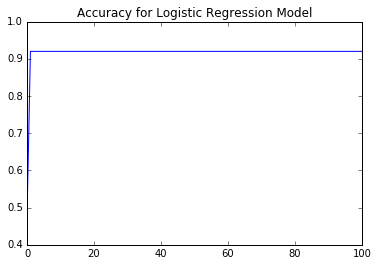

In [123]:
# plot the evolving accuracies
plt.plot(interest,accuracies)
plt.title("Accuracy for Logistic Regression Model")
plt.show()

**<span style="color:teal">We can see that after even a single iteration, we have stabilized in terms of accuracy at around 92%. However, the actual coefficients don't stabilize till around 10 iterations.</span>**

### Write a function to calculate each example's weight

In [103]:
import math

def calcWeight(line):
    """takes a point and returns that point
    with its classification and the weight"""
    
    # grab the values from the line
    values = [float(x) for x in line.split(',')]
    
    # get the class and the coordinates
    x = float(values[0])
    y = float(values[1])
    truth = int(values[2])
    
    # define the weight function
    def weight(x,y):
        return math.sqrt(x**(2) + y **(2))
    
    # get the weight for the point
    wgt = weight(x,y)
    
    # return the point with all the
    # data
    return [x,y,truth,wgt]

### Calculate the weights for the training data

In [108]:
# load in the training data
trainRDD = sc.textFile('train_nl.csv')

# weight it
train_wgt = trainRDD.map(calcWeight)

# print out a sample
print np.array(train_wgt.collect())[0:10]

[[-0.66677651  0.62992274  1.          0.91727508]
 [ 0.32765501 -0.56620453 -1.          0.65417534]
 [-0.20250519  0.05161294  1.          0.20897906]
 [ 0.7290459  -0.42157489  1.          0.84215991]
 [-0.34394326  0.7584167  -1.          0.83276218]
 [ 0.68047352 -0.08827704 -1.          0.68617566]
 [-0.26157763  0.52208947  1.          0.58395228]
 [ 0.29162002 -0.35207817  1.          0.45716657]
 [-0.96350059  0.74657127  1.          1.21889378]
 [ 0.66888864 -0.08600763 -1.          0.67439552]]


### Make a named tuple to help us deal with all our data

In [158]:
from collections import namedtuple
import numpy as np

# create a named tuple type of Point
# that has the values: features,
# class, and weight
Point = namedtuple('Point', 'x y wgt')

# write a function to convert a data 
# to the this format 
def readPoint(line):
    
    # set a blank array to hold
    # the features
    x = []
    
    # loop through all but the last 
    # two elements of the array, and
    # append it to our array
    for i in line[:-2]:
        x.append(float(i))
    
    # append the bias term
    x.append(1.0)
    
    # get the classification
    y = line[-2]
    
    # get the weight
    wgt = line[-1]
    
    return Point(x, y, wgt)

### Convert the training data into our homegrown point

In [159]:
# convert the training data to named tuple points
train = train_wgt.map(readPoint).cache()

# print a sample
print train.collect()[0:10]

[Point(x=[-0.6667765110042355, 0.6299227383386319, 1.0], y=1, wgt=0.9172750797350934), Point(x=[0.3276550088540289, -0.5662045276381993, 1.0], y=-1, wgt=0.6541753373103653), Point(x=[-0.20250519138016065, 0.0516129445782425, 1.0], y=1, wgt=0.20897906254922338), Point(x=[0.7290458998871743, -0.4215748940248314, 1.0], y=1, wgt=0.84215991083306), Point(x=[-0.34394325533068537, 0.7584167005560385, 1.0], y=-1, wgt=0.8327621836813778), Point(x=[0.6804735163940775, -0.08827703698126466, 1.0], y=-1, wgt=0.6861756639315566), Point(x=[-0.2615776286653765, 0.5220894651654919, 1.0], y=1, wgt=0.5839522801179827), Point(x=[0.29162001661399173, -0.35207816936229186, 1.0], y=1, wgt=0.4571665685846325), Point(x=[-0.963500593763634, 0.7465712664634533, 1.0], y=1, wgt=1.218893781299962), Point(x=[0.6688886354181288, -0.08600763046501081, 1.0], y=-1, wgt=0.6743955212556889)]


### Homegrown Logistic Regression Function (unweighted)

In [187]:
import numpy as np

def logisticRegressionGDUW(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    """Logistic Regression function that takes as input
    the data, an initial set of weights, a learning rate,
    a number of iterations, a regularization hyperparameter,
    and the type of regularization.
    It outputs the coefficients for the model."""
    
    # set the feature length by taking the length
    # of the features in the first point
    featureLen = len(data.take(1)[0].x)
    
    # count the number of data points
    n = data.count()
    
    # if the initial coefficients are none,
    # then initalize a random set of coefficients
    # that are equal to the feature length
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    
    # otherwise, set the coefficients to be the 
    # coefficients provided by the user
    else:
        w = wInitial
        
    # loop through the number of iterations 
    # specified by the user
    for i in range(iterations):
        
        # broadcast the coefficients so that 
        # we can hold the coefficients in memory
        wBroadcast = sc.broadcast(w)
        
        # calculate the gradient for each point
        # and then reduce by summing all the 
        # partial gradients 
        
        # the partial gradient is 1 calculated as 
        # using the formula here
        # https://work.caltech.edu/library/093.pdf
        partial_gradient = data.map(lambda point: (1 / \
        (1 + np.exp(-point.y*np.dot(wBroadcast.value, point.x)))-1) * \
                                    point.y * np.array(point.x))
        
        gradient = partial_gradient.reduce(lambda a, b: a + b)
        
        # if the regularization type is 'ridge'
        # then use the 
        if regType == "Ridge":
            
            # multiply the weight vector by 1 to make
            # a copy of the array
            wReg = w * 1
            
            # ignore the last value of weight vector
            # because it is the bias term, 
            # ignored in regularization
            wReg[-1] = 0 
            
        # else if we're using a 'lasso' regularization
        # type
        elif regType == "Lasso":
            
            # multiply the weight vector by 1 to make 
            # a copy of the array
            wReg = w * 1
            
            # ignore the last value of coefficient vector
            # because it is the bias term, 
            # ignored in regularization
            wReg[-1] = 0 
            
            # if the coefficient is greater than 0,
            # make it 1, otherwise make it zero
            wReg = (wReg>0).astype(int) * 2-1
        
        # if no regularlization type is provided,
        # just don't regularize at all
        else:
            wReg = np.zeros(w.shape[0])
            
        # set the gradient equal to itself plus
        # the regularization parameter times the
        # current weights
        # gradient:  gradient of Sqaured Error +
        # gradient of regularized term 
        gradient = gradient + regParam * wReg
        
        # the new set of coefficients is the 
        # current set of coefficients minus
        # the gradient times the learning rate
        # all over the number of exmaples
        w = w - learningRate * gradient / n
    
    # return the coefficients
    return w

In [182]:
# test it out by running a simple
# regression and getting the weights
print "Homebrew logistic regression with 100 iterations:"
print logisticRegressionGDUW(train,regType='Lasso',iterations=100)

Homebrew logistic regression with 100 iterations:
[-0.10165159  0.55552201 -0.33177561]


### Homegrown Logistic Regression Function (weighted)

In [188]:
import numpy as np

def logisticRegressionGDW(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    """Logistic Regression function that takes as input
    the data, an initial set of weights, a learning rate,
    a number of iterations, a regularization hyperparameter,
    and the type of regularization.
    It outputs the coefficients for the model."""
    
    # set the feature length by taking the length
    # of the features in the first point
    featureLen = len(data.take(1)[0].x)
    
    # instead of counting the number of datapoints
    # sum all the weights
    n = data.map(lambda point: point.wgt).reduce(lambda a,b: a + b)
    
    # if the initial coefficients are none,
    # then initalize a random set of coefficients
    # that are equal to the feature length
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    
    # otherwise, set the coefficients to be the 
    # coefficients provided by the user
    else:
        w = wInitial
        
    # loop through the number of iterations 
    # specified by the user
    for i in range(iterations):
        
        # broadcast the coefficients so that 
        # we can hold the coefficients in memory
        wBroadcast = sc.broadcast(w)
        
        # calculate the gradient for each point
        # and then reduce by summing all the 
        # partial gradients 
        
        # the partial gradient is 1 calculated as 
        # using the formula here
        # https://work.caltech.edu/library/093.pdf
        
        # we update the formula to add a term
        # to weight each point
        partial_gradient = data.map(lambda point: (((1 / \
        (1 + np.exp(-point.y*np.dot(wBroadcast.value, point.x)))-1) * \
                                    point.y * np.array(point.x))) * \
                                   point.wgt)
        # we calculate the total gradient by summing across
        # the partial gradients
        gradient = partial_gradient.reduce(lambda a, b: a + b)
        
        # if the regularization type is 'ridge'
        # then use the 
        if regType == "Ridge":
            
            # multiply the weight vector by 1 to make
            # a copy of the array
            wReg = w * 1
            
            # ignore the last value of weight vector
            # because it is the bias term, 
            # ignored in regularization
            wReg[-1] = 0 
            
        # else if we're using a 'lasso' regularization
        # type
        elif regType == "Lasso":
            
            # multiply the weight vector by 1 to make 
            # a copy of the array
            wReg = w * 1
            
            # ignore the last value of coefficient vector
            # because it is the bias term, 
            # ignored in regularization
            wReg[-1] = 0 
            
            # if the coefficient is greater than 0,
            # make it 1, otherwise make it zero
            wReg = (wReg>0).astype(int) * 2-1
        
        # if no regularlization type is provided,
        # just don't regularize at all
        else:
            wReg = np.zeros(w.shape[0])
            
        # set the gradient equal to itself plus
        # the regularization parameter times the
        # current weights
        # gradient:  gradient of Sqaured Error +
        # gradient of regularized term 
        gradient = gradient + regParam * wReg
        
        # the new set of coefficients is the 
        # current set of coefficients minus
        # the gradient times the learning rate
        # all over the number of exmaples
        w = w - learningRate * gradient / n
    
    # return the coefficients
    return w

### Write a function to help compute the accuracy of the home grown model

In [198]:
import numpy as np

def accuracyHome(coefficients,test,thresh=0.5): 
    """a simple function that takes as inputs,
    the coefficients calculated by a logistic
    regression model, and the test data, and 
    uses both to compute the accuracy of the
    model"""
    
    # keep the count of correct and the total
    # count
    total = 0
    correct = 0
    
    # write a subfunction to calculate the
    # the actual predictions
    def predictLog(point):
        
        # get the prediction from the log odds by 
        # converting the log-odds back to calculate
        # the prediction
        prediction = 1 / (1+np.exp(-np.dot(coefficients,point)))
        
        # use the threshold to establish the prediction
        predict = -1.0
        if prediction > 0.5:
            predict = 1.0
        
        # return the prediction
        return predict
    
    # loop through each test example
    for i in test: 
        
        # get the x (features) from the point
        # and append a 1 for the bias term
        x = list(i[0:2])
        x.append(1.0)
        
        # get the prediction for this point
        predict = predictLog(x)
        
        # if the prediction is right, then 
        # increment correct. always increment 
        # total
        total = total + 1
        if predict == i[2]:
            correct = correct + 1
    
    # return the accuracy
    accur = float(correct) / float(total)
    return accur

### Run the homegrown model for many iterations and look for convergence

In [199]:
# set the iterations of interest for plotting
interest = [0,1,2,3,4,5,10,20,35,60,100]

# create an array to store the accuracies
accuracies = []

# loop through all the intersting iterations
for i in interest:
    
    # grab the coefficients
    coefficients = logisticRegressionGDW(train, regType='Lasso',iterations=i)
    
    # compute the accuracy
    accur = accuracyHome(coefficients,test_nl)
    
    # add the accuracy to the list
    accuracies.append(accur)
    
    # print out the accuracy and the iteration
    print "Iteration",i
    print "Accuracy:",accur
    print "Coefficients:",coefficients
    print "\n"

Iteration 0
Accuracy: 0.87
Coefficients: [ 0.13130022  1.39845874 -0.07275296]


Iteration 1
Accuracy: 0.14
Coefficients: [ 0.56990619  0.03133693  0.12013405]


Iteration 2
Accuracy: 0.52
Coefficients: [-0.5228003  -0.15189114  1.25087885]


Iteration 3
Accuracy: 0.35
Coefficients: [ 1.12528197 -0.74934186 -0.98882026]


Iteration 4
Accuracy: 0.52
Coefficients: [ 1.10565593 -0.43907647  1.52753988]


Iteration 5
Accuracy: 0.44
Coefficients: [-0.42033692 -0.58857714 -0.26308081]


Iteration 10
Accuracy: 0.59
Coefficients: [-0.88010529 -0.19830175 -0.61124347]


Iteration 20
Accuracy: 0.65
Coefficients: [-0.14017454  0.98315338 -0.77679797]


Iteration 35
Accuracy: 0.88
Coefficients: [-1.28399497  0.17235407  0.28482233]


Iteration 60
Accuracy: 0.85
Coefficients: [ 0.2019071   2.33761949  0.17697976]


Iteration 100
Accuracy: 0.84
Coefficients: [-1.91936521 -0.53283814 -0.11461893]




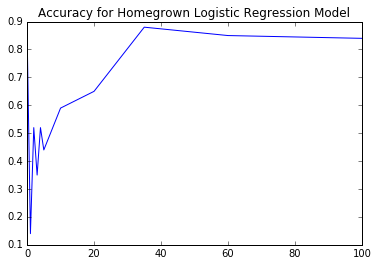

In [201]:
# plot the evolving accuracies
plt.plot(interest,accuracies)
plt.title("Accuracy for Homegrown Logistic Regression Model")
plt.show()

It does not appear that my coefficients are **converging**, even though my accuracies improve drastically with more iterations (before stabilizing). 

The Spark machine learning library does not have a native way to weight examples in Python. There does appear to be an [option](https://spark.apache.org/docs/1.5.2/api/java/org/apache/spark/mllib/optimization/L1Updater.html) to use weights when using Spark in Scala. However, I could find no such option in Python.

***
## <span style="color:teal">HW11.4 SVMs</span>
<span style="color:gray">Use the non-linearly separable training and testing datasets from HW11.3 in this problem.
<br><br>
Use the non-linearly separable training and testing datasets from HW11.3 in this problem.
<br><br>
Using MLLib train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words.
<br><br>
HW11.4.1 [Optional] Derive and Implement in Spark a weighted hard linear svm classification learning algorithm. Feel free to use the following notebook as a starting point SVM Notebook.<br>
Evaluate your homegrown weighted linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3 (linearly separable dataset). Report misclassification error (1 - Accuracy) and how many iterations does it took to converge? How many support vectors do you end up with?<br>
Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set.
<br><br>
HW11.4.2 [Optional] Repeat HW11.4.2 using a soft SVM and a nonlinearly separable datasets. Compare the error rates that you get here with the error rates you achieve using MLLib's soft SVM. Report the number of support vectors in both cases (may not be available the MLLib implementation).</span>

### Write function to turn data into Spark's labelled points

In [110]:
from pyspark.mllib.regression import LabeledPoint

def parsePoint(line):
    """takes each line in the format [x,y,label] and 
    converts it to Spark labelled points RDD"""
    
    # grab the values from the line
    values = [float(x) for x in line.split(',')]
    
    # if the classification is -1, then
    # convert it to zero
    if values[2] == -1:
        values[2] = 0
    
    return LabeledPoint(values[2], values[0:2])

### Convert the data to a format readable by Spark's library

In [111]:
import numpy as np

# convert the data to an RDD
trainRDD = sc.textFile('train_nl.csv')

# turn the data into labelled points
trainRDD = trainRDD.map(parsePoint).cache()

# print out a sample of what we've done
print trainRDD.collect()[0:5]

[LabeledPoint(1.0, [-0.666776511004,0.629922738339]), LabeledPoint(0.0, [0.327655008854,-0.566204527638]), LabeledPoint(1.0, [-0.20250519138,0.0516129445782]), LabeledPoint(1.0, [0.729045899887,-0.421574894025]), LabeledPoint(0.0, [-0.343943255331,0.758416700556])]


### Train a SVM model using Spark's library

In [129]:
from pyspark.mllib.classification import SVMWithSGD

# some test data that we can use based on the documentation
#data = sc.parallelize([LabeledPoint(0.0, [0.0, 1.0]),LabeledPoint(1.0, [1.0, 0.0])])

# set the iterations of interest for plotting
interest = [0,1,2,3,4,5,10,20,35,60,75,90,100]

# create an array to store the accuracies
accuracies = []

# loop through all the intersting iterations
for i in interest:
    
    # set the model
    model = SVMWithSGD.train(trainRDD,regType='l1',iterations=i)
    
    # compute the accuracy
    accur = accuracy(model,test_nl)
    
    # append the accuracy to accuracies
    accuracies.append(accur)
    
    # compute the misclassification rate
    misclas = 1.0 - accur
    
    # print out the accuracy and the iteration
    print "Iteration",i
    print "Misclassification:",misclas
    print "Coefficients:",model.weights
    print "\n"

Iteration 0
Misclassification: 0.52
Coefficients: [0.0,0.0]


Iteration 1
Misclassification: 0.08
Coefficients: [-0.447709021287,0.397602060893]


Iteration 2
Misclassification: 0.08
Coefficients: [-0.764287106238,0.678749174364]


Iteration 3
Misclassification: 0.08
Coefficients: [-0.922558334871,0.81955765388]


Iteration 4
Misclassification: 0.08
Coefficients: [-1.01043935566,0.897405969077]


Iteration 5
Misclassification: 0.08
Coefficients: [-1.07440503792,0.952233063804]


Iteration 10
Misclassification: 0.08
Coefficients: [-1.26227188448,1.10911905912]


Iteration 20
Misclassification: 0.08
Coefficients: [-1.4094900117,1.25685853017]


Iteration 35
Misclassification: 0.08
Coefficients: [-1.51991317389,1.37253485294]


Iteration 60
Misclassification: 0.08
Coefficients: [-1.63457455404,1.44165575892]


Iteration 75
Misclassification: 0.08
Coefficients: [-1.66839254922,1.46713553171]


Iteration 90
Misclassification: 0.08
Coefficients: [-1.67152715048,1.46975541981]


Iteration 100

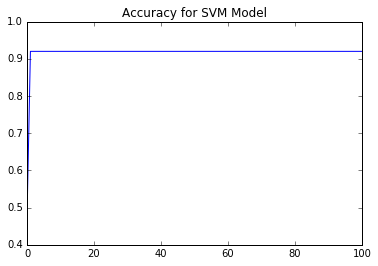

In [119]:
# plot the evolving accuracies
plt.plot(interest,accuracies)
plt.title("Accuracy for SVM Model")
plt.show()

**<span style="color:teal">We can see that after even a single iteration, we have stabilized in terms of accuracy at around 92%. However, the coefficients don't actually converge till about 90 iterations.</span>**

### <span style="color:sienna">Optional: Write our own homegrown version of SVM (unweighted)</span>
We borrow from the [sample notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dm2l73iznde7y4f/SVM-Notebook-Linear-Kernel-2015-06-19.ipynb) and start with an unweighted implementation before moving to a fully weighted implementation </span>

In [221]:
import numpy as np

# gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi(1   –    yi(w’xi – b))+
# gradient 
#   λw               if      yi(w’xi – b))  > 1    #correctly classified
#   λw  + yi xi      Otherwise                    #incorrectly classified
#--------------------------------
# Wt+1  = wt + average(gradient)
# Wt+1  = wt + average(regularization + hinge loss)
def SVM_GDUW(data,w=None,eta=0.01,iter_num=1000,regPara=0.01,stopCriteria=0.0001):
    """a function that produces a support vector machine
    from an inputted set of data,
    an optional initial set of coefficients, a learning
    rate (eta), a number of iterations, a regularization
    parameter and a stopping criteria"""

    # this line of code prepends the classification
    # to the data. however, for our data, its already
    # all combined so we comment out this line
    # dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1)).cache() #prepend y to X
    
    # grab the feature length
    featureLen = len(data.take(1)[0].x)
    
    # set the number of data points
    n = data.count()
    
    # if the user did not provide an initial set
    # of coefficients, then we generate a random
    # set
    if w==None:
        w = np.random.normal(size=featureLen)
        
    # loop through all the iterations
    for i in range(iter_num):       #label * margin
        
        # create the support vector by taking the
        # classification and multiplying it by the
        # dot product of the weights and the x value
        sv = data.filter(lambda point: point.y * np.dot(w,point.x)<1)
        
        # if the support vector is empty (that means
        # that it has converged), then go ahead and
        # break out
        if sv.isEmpty(): 
            break       
        
        # set the gradient using the hing loss function
        # to first elements multiplied by the rest of
        # the elements and all summed together
        g = -sv.map(lambda point: point.y*np.array(point.x)).reduce(lambda x,y:x+y)/n
        
        # make a copy of the coefficients
        wreg = w*1
        
        # set the bias term to 0 so that we
        # ignore it during regularization
        wreg[-1] = 0 
        
        # calculate the change in the 
        # gradient as the learning rate
        # times the gradient plus the 
        # the regularization parameter 
        # times the new coefficients
        wdelta = eta*(g+regPara*wreg)
        
        # if the amount of change we're
        # about to use is less than the
        # stopping criteria that we've
        # set, then we we break out of
        # the loop and stop doing any
        # further iterations
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)):
            break
        
        # otherwise, if we're still going,
        # go ahead and update the coefficients
        w = w - wdelta
        
    # return the coefficients
    return w

In [219]:
# test it out
SVM_GDUW(train,iter_num=50)

array([ 0.20659619, -1.07756549, -1.71936608])

### <span style="color:sienna">Optional: Write our own homegrown version of SVM (weighted)</span>

In [225]:
import numpy as np

# gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi(1   –    yi(w’xi – b))+
# gradient 
#   λw               if      yi(w’xi – b))  > 1    #correctly classified
#   λw  + yi xi      Otherwise                    #incorrectly classified
#--------------------------------
# Wt+1  = wt + average(gradient)
# Wt+1  = wt + average(regularization + hinge loss)
def SVM_GDW(data,w=None,eta=0.01,iter_num=1000,regPara=0.01,stopCriteria=0.0001):
    """a function that produces a support vector machine
    from an inputted set of data,
    an optional initial set of coefficients, a learning
    rate (eta), a number of iterations, a regularization
    parameter and a stopping criteria"""

    # this line of code prepends the classification
    # to the data. however, for our data, its already
    # all combined so we comment out this line
    # dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1)).cache() #prepend y to X
    
    # grab the feature length
    featureLen = len(data.take(1)[0].x)
    
    # instead of counting the number of datapoints
    # sum all the weights
    n = data.map(lambda point: point.wgt).reduce(lambda a,b: a + b)
    
    # if the user did not provide an initial set
    # of coefficients, then we generate a random
    # set
    if w==None:
        w = np.random.normal(size=featureLen)
        
    # loop through all the iterations
    for i in range(iter_num):       #label * margin
        
        # create the support vector by taking the
        # classification and multiplying it by the
        # dot product of the weights and the x value
        sv = data.filter(lambda point: point.y * np.dot(w,point.x)<1)
        
        # if the support vector is empty (that means
        # that it has converged), then go ahead and
        # break out
        if sv.isEmpty(): 
            break       
        
        # set the gradient using the hinge loss function
        # to first elements multiplied by the rest of
        # the elements and all summed together
        g = -sv.map(lambda point: point.y*np.array(point.x)*point.wgt).reduce(lambda x,y:x+y)/n
        
        # make a copy of the coefficients
        wreg = w*1
        
        # set the bias term to 0 so that we
        # ignore it during regularization
        wreg[-1] = 0 
        
        # calculate the change in the 
        # gradient as the learning rate
        # times the gradient plus the 
        # the regularization parameter 
        # times the new coefficients
        wdelta = eta*(g+regPara*wreg)
        
        # if the amount of change we're
        # about to use is less than the
        # stopping criteria that we've
        # set, then we we break out of
        # the loop and stop doing any
        # further iterations
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)):
            break
        
        # otherwise, if we're still going,
        # go ahead and update the coefficients
        w = w - wdelta
        
    # return the coefficients
    return w

In [226]:
# test it out
SVM_GDW(train,iter_num=50)

array([-0.74760737, -1.78180941, -0.93883008])

### Write a function to compute the accuracy of our homegrown SVM models

In [229]:
import numpy as np

def accuracySVM(coefficients,test,thresh=0.5):
    """a simple function that takes the coefficients
    of a support vector machine and uses them
    to predict the classifications of test data"""
    
    # set up counters for the total and the
    # number of correct examples
    total = 0
    correct = 0
    
    # sub functiont that predicts 
    # each individual point
    def prediction(point):
        prod = np.dot(point,coefficients)
        
        # compare it to 
        predict = -1.0
        if prod > 0.5: 
            predict = 1.0
        
        # return the class that we predicted
        return predict
    
    # loop through each test example
    for i in test: 
        
        # get the x (features) from the point
        # and append a 1 for the bias term
        x = list(i[0:2])
        x.append(1.0)
        
        # get the prediction for this point
        predict = prediction(x)
        
        # if the prediction is right, then 
        # increment correct. always increment 
        # total
        total = total + 1
        if predict == i[2]:
            correct = correct + 1
        
    # compute the actual accuracy
    accur = float(correct)/float(total)
    
    # return the accuracy
    return accur

### Run our homegrown model for a number of iterations to test convergence

In [234]:
# set the iterations of interest for plotting
interest = [0,1,2,3,4,5,10,20,35,60,100, 250, 500, 1000, 1500]

# create an array to store the accuracies
accuracies = []

# loop through all the intersting iterations
for i in interest:
    
    # grab the coefficients
    coefficients = SVM_GDW(train,iter_num=i)
    
    # compute the accuracy
    accur = accuracySVM(coefficients,test_nl)
    
    # add the accuracy to the list
    accuracies.append(accur)
    
    # print out the accuracy and the iteration
    print "Iteration",i
    print "Accuracy:",accur
    print "Coefficients:",coefficients
    print "\n"

Iteration 0
Accuracy: 0.48
Coefficients: [-0.74759883 -0.07484864 -1.07809815]


Iteration 1
Accuracy: 0.68
Coefficients: [ 0.81155744  2.61991941 -0.38742666]


Iteration 2
Accuracy: 0.21
Coefficients: [ 0.04803298 -1.9637259  -0.19864101]


Iteration 3
Accuracy: 0.25
Coefficients: [ 0.76904408  0.03922179  0.7571654 ]


Iteration 4
Accuracy: 0.48
Coefficients: [-0.0823882  -0.10741338 -0.90256635]


Iteration 5
Accuracy: 0.91
Coefficients: [-0.83038039  0.49219454  0.63233672]


Iteration 10
Accuracy: 0.52
Coefficients: [-0.14639041  0.53860456  1.29556984]


Iteration 20
Accuracy: 0.79
Coefficients: [-0.38940474  0.59443796  0.89203248]


Iteration 35
Accuracy: 0.48
Coefficients: [-0.31948492 -0.52346544 -1.11545924]


Iteration 60
Accuracy: 0.48
Coefficients: [-0.29943391  1.6402978  -1.37812231]


Iteration 100
Accuracy: 0.67
Coefficients: [-1.25080583 -0.56100595 -0.10016891]


Iteration 250
Accuracy: 0.73
Coefficients: [-1.18131614  0.45598356 -0.30530493]


Iteration 500
Accura

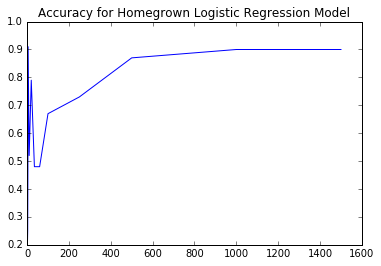

In [235]:
# plot the evolving accuracies
plt.plot(interest,accuracies)
plt.title("Accuracy for Homegrown Logistic Regression Model")
plt.show()

Although we see an increasing level of accuracy (that stabilizes eventually), we *unfortunately* don't see the convergence of the weights for the model. 